# 3. Advanced GRI Analysis

This notebook demonstrates advanced analysis techniques for understanding representativeness gaps and comparing surveys using the Global Representativeness Index.

## Overview

Beyond basic GRI scores, this analysis helps you:
1. **Identify specific over/under-represented groups**
2. **Understand the magnitude of representativeness gaps**
3. **Compare surveys over time or across methodologies**
4. **Generate actionable insights for improving sample balance**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from typing import List, Tuple

# Add the gri module to the path
sys.path.append('..')
from gri.calculator import calculate_gri, calculate_diversity_score
from gri.utils import load_data

# Set plotting style
plt.style.use('default')
sns.set_palette('RdYlBu_r')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)

## 1. Load Data and Previous Results

In [2]:
# Load actual GD survey data
survey_options = {
    'GD1': '../data/processed/gd1_demographics.csv',
    'GD2': '../data/processed/gd2_demographics.csv', 
    'GD3': '../data/processed/gd3_demographics.csv'
}

# Choose which survey to analyze (default: GD3)
selected_survey = 'GD3'
survey_data = load_data(survey_options[selected_survey])

# Load benchmark data
benchmark_age_gender = load_data('../data/processed/benchmark_country_gender_age.csv')
benchmark_religion = load_data('../data/processed/benchmark_country_religion.csv')
benchmark_environment = load_data('../data/processed/benchmark_country_environment.csv')

# Load previous GRI results if they exist for this survey
import json
import os
results_file = f'../data/processed/{selected_survey.lower()}_gri_results.json'
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        gri_results = json.load(f)
    print(f"Data loaded successfully for {selected_survey}")
    print(f"Survey participants: {len(survey_data)}")
    print(f"Average GRI: {gri_results['average_gri']:.4f}")
else:
    print(f"GRI results not found for {selected_survey}. Calculating basic results here.")
    # Calculate basic GRI scores for this notebook
    gri_age_gender = calculate_gri(survey_data, benchmark_age_gender, ['country', 'gender', 'age_group'])
    gri_religion = calculate_gri(survey_data, benchmark_religion, ['country', 'religion'])
    gri_environment = calculate_gri(survey_data, benchmark_environment, ['country', 'environment'])
    
    gri_results = {
        'survey_name': selected_survey,
        'average_gri': (gri_age_gender + gri_religion + gri_environment) / 3,
        'gri_country_gender_age': gri_age_gender,
        'gri_country_religion': gri_religion,
        'gri_country_environment': gri_environment
    }
    print(f"Data loaded and basic GRI calculated for {selected_survey}")
    print(f"Survey participants: {len(survey_data)}")
    print(f"Calculated Average GRI: {gri_results['average_gri']:.4f}")

# Show survey composition
print(f"\n{selected_survey} Survey Composition:")
print(f"  Countries: {survey_data['country'].nunique()} ({list(survey_data['country'].value_counts().head().index)})")
print(f"  Age groups: {list(survey_data['age_group'].value_counts().index)}")
print(f"  Gender: {dict(survey_data['gender'].value_counts())}")
print(f"  Environment: {dict(survey_data['environment'].value_counts())}")

Data loaded successfully for GD3
Survey participants: 970
Average GRI: 0.4261

GD3 Survey Composition:
  Countries: 63 (['India', 'Kenya', 'China', 'United States', 'Indonesia'])
  Age groups: ['26-35', '18-25', '36-45', '46-55', '56-65', '65+']
  Gender: {'Male': np.int64(488), 'Female': np.int64(482)}
  Environment: {'Urban': np.int64(883), 'Rural': np.int64(87)}


In [3]:
# Run top contributing segments analysis
import subprocess
import sys

# Run the segments analysis script
survey_file = f'../data/processed/{selected_survey.lower()}_demographics.csv'
result = subprocess.run([
    sys.executable, '../scripts/analyze_top_segments.py', 
    survey_file, '--top-n', '15', '--output-dir', '../analysis_output'
], capture_output=True, text=True)

if result.returncode == 0:
    print("✅ Top segments analysis completed successfully!")
    print(result.stdout.split('Analysis date:')[0].strip())  # Show summary without the full output
else:
    print("❌ Error running segments analysis:")
    print(result.stderr)

# Load the generated analysis results
segments_file = f'../analysis_output/{selected_survey.lower()}_top_contributing_segments.csv'
if os.path.exists(segments_file):
    top_segments = pd.read_csv(segments_file)
    print(f"\nLoaded top {len(top_segments)} contributing segments from analysis")
else:
    print("Warning: Could not load segments analysis results")

❌ Error running segments analysis:
Traceback (most recent call last):
  File "/Users/evan/Documents/GitHub/gri/notebooks/../scripts/analyze_top_segments.py", line 269, in <module>
    main()
  File "/Users/evan/Documents/GitHub/gri/notebooks/../scripts/analyze_top_segments.py", line 251, in main
    results = analyze_top_contributing_segments(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/evan/Documents/GitHub/gri/notebooks/../scripts/analyze_top_segments.py", line 165, in analyze_top_contributing_segments
    combined_segments = pd.concat(all_segments, ignore_index=True)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/evan/Documents/GitHub/gri/venv/lib/python3.12/site-packages/pandas/core/reshape/concat.py", line 382, in concat
    op = _Concatenator(
         ^^^^^^^^^^^^^^
  File "/Users/evan/Documents/GitHub/gri/venv/lib/python3.12/site-packages/pandas/core/reshape/concat.py", line 445, in __init__
    objs, keys = self._clean_key

In [4]:
# Display top contributing segments
if 'top_segments' in locals():
    print("=" * 80)
    print(f"TOP 10 SEGMENTS CONTRIBUTING TO {selected_survey} GRI DEVIATION")
    print("=" * 80)
    
    top_10 = top_segments.head(10)
    total_contribution = top_10['gri_contribution_points'].sum()
    
    for i, (_, segment) in enumerate(top_10.iterrows(), 1):
        # Format representation percentage
        if segment['over_under_representation_pct'] == np.inf:
            rep_str = "∞% (new segment)"
        elif segment['over_under_representation_pct'] > 1000:
            rep_str = f"+{segment['over_under_representation_pct']:.0f}%"
        else:
            rep_str = f"{segment['over_under_representation_pct']:+.1f}%"
        
        print(f"{i:2d}. {segment['stratum_id']}")
        print(f"    Dimension: {segment['dimension']}")
        print(f"    GRI Impact: {segment['gri_contribution_points']:.3f} percentage points")
        print(f"    Deviation: {segment['deviation_percentage_points']:+.2f} pp from expected")
        print(f"    Representation: {rep_str}")
        print(f"    Status: {segment['representation_category']}")
        print()
    
    print(f"These top 10 segments contribute {total_contribution:.2f} percentage points")
    print(f"to the total GRI deviation across all dimensions.")
    
    # Show category breakdown
    category_counts = top_10['representation_category'].value_counts()
    print(f"\nTop 10 Segment Categories:")
    for category, count in category_counts.items():
        print(f"  {category}: {count} segments")
else:
    print("No segment analysis data available.")

TOP 10 SEGMENTS CONTRIBUTING TO GD3 GRI DEVIATION
 1. country:India × environment:Urban
    Dimension: Country × Environment
    GRI Impact: 7.500 percentage points
    Deviation: +15.00 pp from expected
    Representation: +831.7%
    Status: Highly Over-represented

 2. country:Kenya × environment:Urban
    Dimension: Country × Environment
    GRI Impact: 6.829 percentage points
    Deviation: +13.66 pp from expected
    Representation: +25336%
    Status: Highly Over-represented

 3. country:Kenya × religion:Christianity
    Dimension: Country × Religion
    GRI Impact: 6.771 percentage points
    Deviation: +13.54 pp from expected
    Representation: +8020%
    Status: Highly Over-represented

 4. country:World × religion:Christianity
    Dimension: Country × Religion
    GRI Impact: 5.338 percentage points
    Deviation: -10.68 pp from expected
    Representation: -100.0%
    Status: Missing

 5. country:ASIA × environment:Rural
    Dimension: Country × Environment
    GRI Impact:

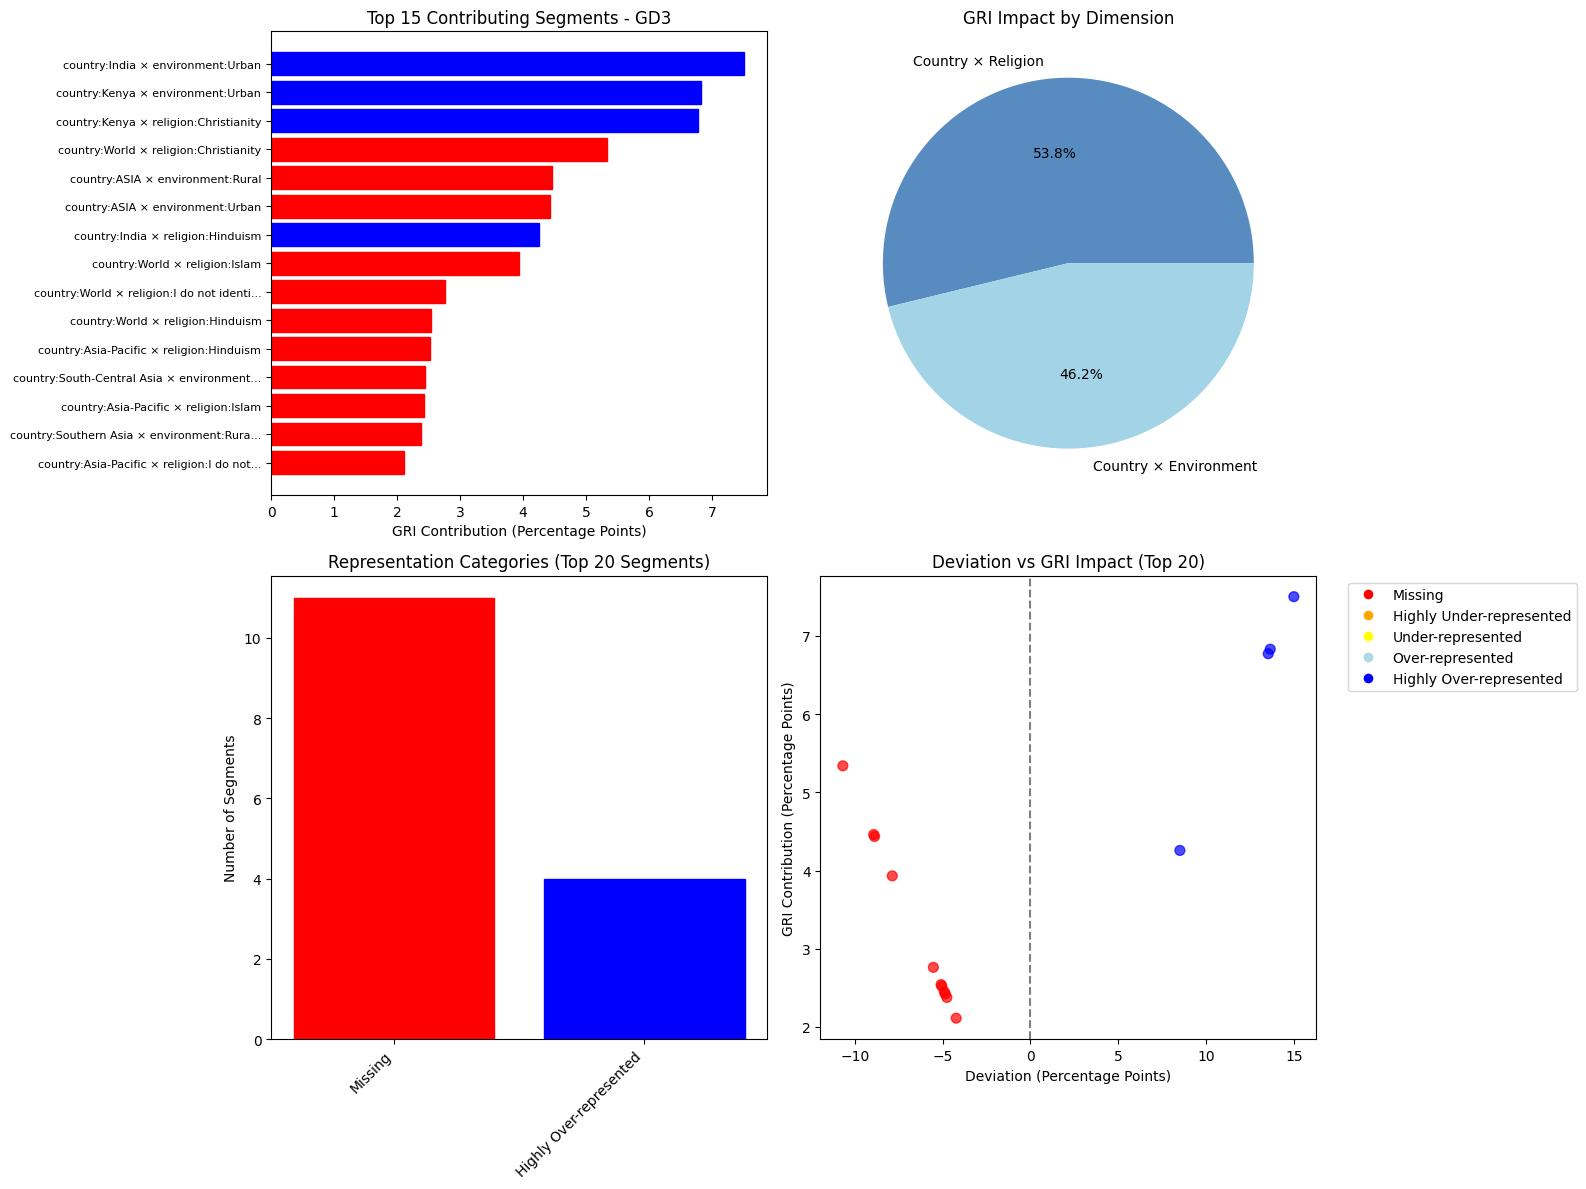

\n📊 Visualization shows the GD3 survey's main representativeness challenges:
• Red/Orange: Missing or under-represented segments that should be recruited
• Blue: Over-represented segments that could be reduced in future sampling
• The scatter plot shows how deviation magnitude correlates with GRI impact


In [5]:
# Visualize top contributing segments
if 'top_segments' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 15 segments by GRI contribution
    top_15 = top_segments.head(15)
    
    # Truncate long segment names for display
    segment_names = [name[:40] + "..." if len(name) > 40 else name 
                    for name in top_15['stratum_id']]
    
    bars = axes[0,0].barh(range(len(top_15)), top_15['gri_contribution_points'])
    axes[0,0].set_yticks(range(len(top_15)))
    axes[0,0].set_yticklabels(segment_names, fontsize=8)
    axes[0,0].set_xlabel('GRI Contribution (Percentage Points)')
    axes[0,0].set_title(f'Top 15 Contributing Segments - {selected_survey}')
    axes[0,0].invert_yaxis()
    
    # Color bars by representation category
    colors = {'Missing': 'red', 'Highly Under-represented': 'orange', 
              'Under-represented': 'yellow', 'Over-represented': 'lightblue',
              'Highly Over-represented': 'blue'}
    for i, (_, segment) in enumerate(top_15.iterrows()):
        bars[i].set_color(colors.get(segment['representation_category'], 'gray'))
    
    # 2. Contribution by dimension
    dim_contrib = top_segments.groupby('dimension')['gri_contribution_points'].sum().sort_values(ascending=False)
    axes[0,1].pie(dim_contrib.values, labels=dim_contrib.index, autopct='%1.1f%%')
    axes[0,1].set_title('GRI Impact by Dimension')
    
    # 3. Representation categories distribution
    if len(top_segments) > 0:
        category_counts = top_segments.head(20)['representation_category'].value_counts()
        bars2 = axes[1,0].bar(range(len(category_counts)), category_counts.values)
        axes[1,0].set_xticks(range(len(category_counts)))
        axes[1,0].set_xticklabels(category_counts.index, rotation=45, ha='right')
        axes[1,0].set_ylabel('Number of Segments')
        axes[1,0].set_title('Representation Categories (Top 20 Segments)')
        
        # Color bars by category
        for i, cat in enumerate(category_counts.index):
            bars2[i].set_color(colors.get(cat, 'gray'))
    
    # 4. Deviation vs Contribution scatter
    scatter_data = top_segments.head(20)
    scatter = axes[1,1].scatter(scatter_data['deviation_percentage_points'], 
                               scatter_data['gri_contribution_points'],
                               c=[colors.get(cat, 'gray') for cat in scatter_data['representation_category']],
                               alpha=0.7, s=50)
    axes[1,1].set_xlabel('Deviation (Percentage Points)')
    axes[1,1].set_ylabel('GRI Contribution (Percentage Points)')
    axes[1,1].set_title('Deviation vs GRI Impact (Top 20)')
    axes[1,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=8, label=category)
                      for category, color in colors.items()]
    axes[1,1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\\n📊 Visualization shows the {selected_survey} survey's main representativeness challenges:")
    print("• Red/Orange: Missing or under-represented segments that should be recruited")
    print("• Blue: Over-represented segments that could be reduced in future sampling")
    print("• The scatter plot shows how deviation magnitude correlates with GRI impact")
else:
    print("No segment data available for visualization.")

In [6]:
# Generate actionable recommendations
if 'top_segments' in locals():
    print("🎯 ACTIONABLE RECOMMENDATIONS FOR IMPROVING REPRESENTATIVENESS")
    print("=" * 80)
    
    # Analyze patterns in top contributing segments
    over_rep = top_segments[top_segments['representation_category'].isin(['Over-represented', 'Highly Over-represented'])].head(5)
    under_rep = top_segments[top_segments['representation_category'].isin(['Under-represented', 'Highly Under-represented'])].head(5)
    missing = top_segments[top_segments['representation_category'] == 'Missing'].head(5)
    
    if len(over_rep) > 0:
        print("\\n📉 REDUCE RECRUITMENT FROM OVER-REPRESENTED SEGMENTS:")
        for _, segment in over_rep.iterrows():
            current_pct = segment['sample_proportion'] * 100
            target_pct = segment['population_proportion'] * 100
            reduction = current_pct - target_pct
            print(f"  • {segment['stratum_id']}")
            print(f"    Current: {current_pct:.2f}% → Target: {target_pct:.2f}% (reduce by {reduction:.2f} pp)")
    
    if len(under_rep) > 0:
        print("\\n📈 INCREASE RECRUITMENT FROM UNDER-REPRESENTED SEGMENTS:")
        for _, segment in under_rep.iterrows():
            current_pct = segment['sample_proportion'] * 100
            target_pct = segment['population_proportion'] * 100
            increase = target_pct - current_pct
            print(f"  • {segment['stratum_id']}")
            print(f"    Current: {current_pct:.2f}% → Target: {target_pct:.2f}% (increase by {increase:.2f} pp)")
    
    if len(missing) > 0:
        print("\\n🎯 RECRUIT FROM MISSING SEGMENTS:")
        for _, segment in missing.iterrows():
            target_pct = segment['population_proportion'] * 100
            print(f"  • {segment['stratum_id']}")
            print(f"    Target: {target_pct:.2f}% (currently 0%)")
    
    # Calculate potential GRI improvement
    top_10_impact = top_segments.head(10)['gri_contribution_points'].sum()
    current_gri = gri_results.get('average_gri', 0)
    potential_gri = current_gri + (top_10_impact / 100)
    
    print(f"\\n💡 IMPACT ANALYSIS:")
    print(f"  Current Average GRI: {current_gri:.4f}")
    print(f"  Top 10 segments contribute: {top_10_impact:.2f} percentage points of deviation")
    print(f"  Potential GRI if top issues addressed: {potential_gri:.4f}")
    print(f"  Estimated improvement: +{(potential_gri - current_gri):.4f} GRI points")
    
    # Priority recommendations by dimension
    print(f"\\n🔍 DIMENSION-SPECIFIC PRIORITIES:")
    dim_priorities = top_segments.head(15).groupby('dimension')['gri_contribution_points'].sum().sort_values(ascending=False)
    for dim, impact in dim_priorities.items():
        print(f"  • {dim}: {impact:.2f} pp total impact - High priority for rebalancing")
    
    print(f"\\n📋 NEXT STEPS:")
    print(f"  1. Use the detailed segment analysis files in analysis_output/ for recruitment planning")
    print(f"  2. Focus first on the top 5-10 contributing segments for maximum impact")
    print(f"  3. Consider stratified sampling quotas for future {selected_survey} surveys")
    print(f"  4. Monitor progress by re-running this analysis after recruitment adjustments")
else:
    print("No segment analysis available for generating recommendations.")

🎯 ACTIONABLE RECOMMENDATIONS FOR IMPROVING REPRESENTATIVENESS
\n📉 REDUCE RECRUITMENT FROM OVER-REPRESENTED SEGMENTS:
  • country:India × environment:Urban
    Current: 16.80% → Target: 1.80% (reduce by 15.00 pp)
  • country:Kenya × environment:Urban
    Current: 13.71% → Target: 0.05% (reduce by 13.66 pp)
  • country:Kenya × religion:Christianity
    Current: 13.71% → Target: 0.17% (reduce by 13.54 pp)
  • country:India × religion:Hinduism
    Current: 13.30% → Target: 4.79% (reduce by 8.51 pp)
\n🎯 RECRUIT FROM MISSING SEGMENTS:
  • country:World × religion:Christianity
    Target: 10.68% (currently 0%)
  • country:ASIA × environment:Rural
    Target: 8.92% (currently 0%)
  • country:ASIA × environment:Urban
    Target: 8.87% (currently 0%)
  • country:World × religion:Islam
    Target: 7.86% (currently 0%)
  • country:World × religion:I do not identify with any religious group or faith
    Target: 5.52% (currently 0%)
\n💡 IMPACT ANALYSIS:
  Current Average GRI: 0.4261
  Top 10 segment

## 2. Top Contributing Segments Analysis

Understanding which demographic segments contribute most to GRI deviations helps identify specific groups that are over- or under-represented, providing actionable insights for improving survey balance.

**Key Metrics:**
- **GRI Contribution**: How many percentage points each segment contributes to the overall GRI gap
- **Deviation**: How many percentage points the segment deviates from expected representation  
- **Representation Ratio**: How over/under-represented the segment is (as a percentage)

Let's analyze the segments that most impact the representativeness of our survey.